In [7]:
# importing packages and modules
import numpy as np
#import autograd.numpy as jnp
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1, dglm_hmm2
from scipy.stats import multivariate_normal, norm
#from autograd import value_and_grad

colormap = ['rebeccapurple','teal','darkturquoise','springgreen']
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
sns.set_context("talk")

ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [27]:
exampleSubject = 'ibl_witten_07'

In [28]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 5

D = 4 # number of features
sessStop = -1 # last session to use in fitting

K = 3
truepi = np.ones((K))/K

x, y, sessInd, correctSide = get_mouse_design(dfAll, exampleSubject, sessStop=sessStop, D=4)
biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, exampleSubject, sessInd, sessStop)
N = sessInd[-1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,2)
presentAll = np.ones((N))

Text(762.4583333333334, 0.5, 'Delta Test Ll (per trial)')

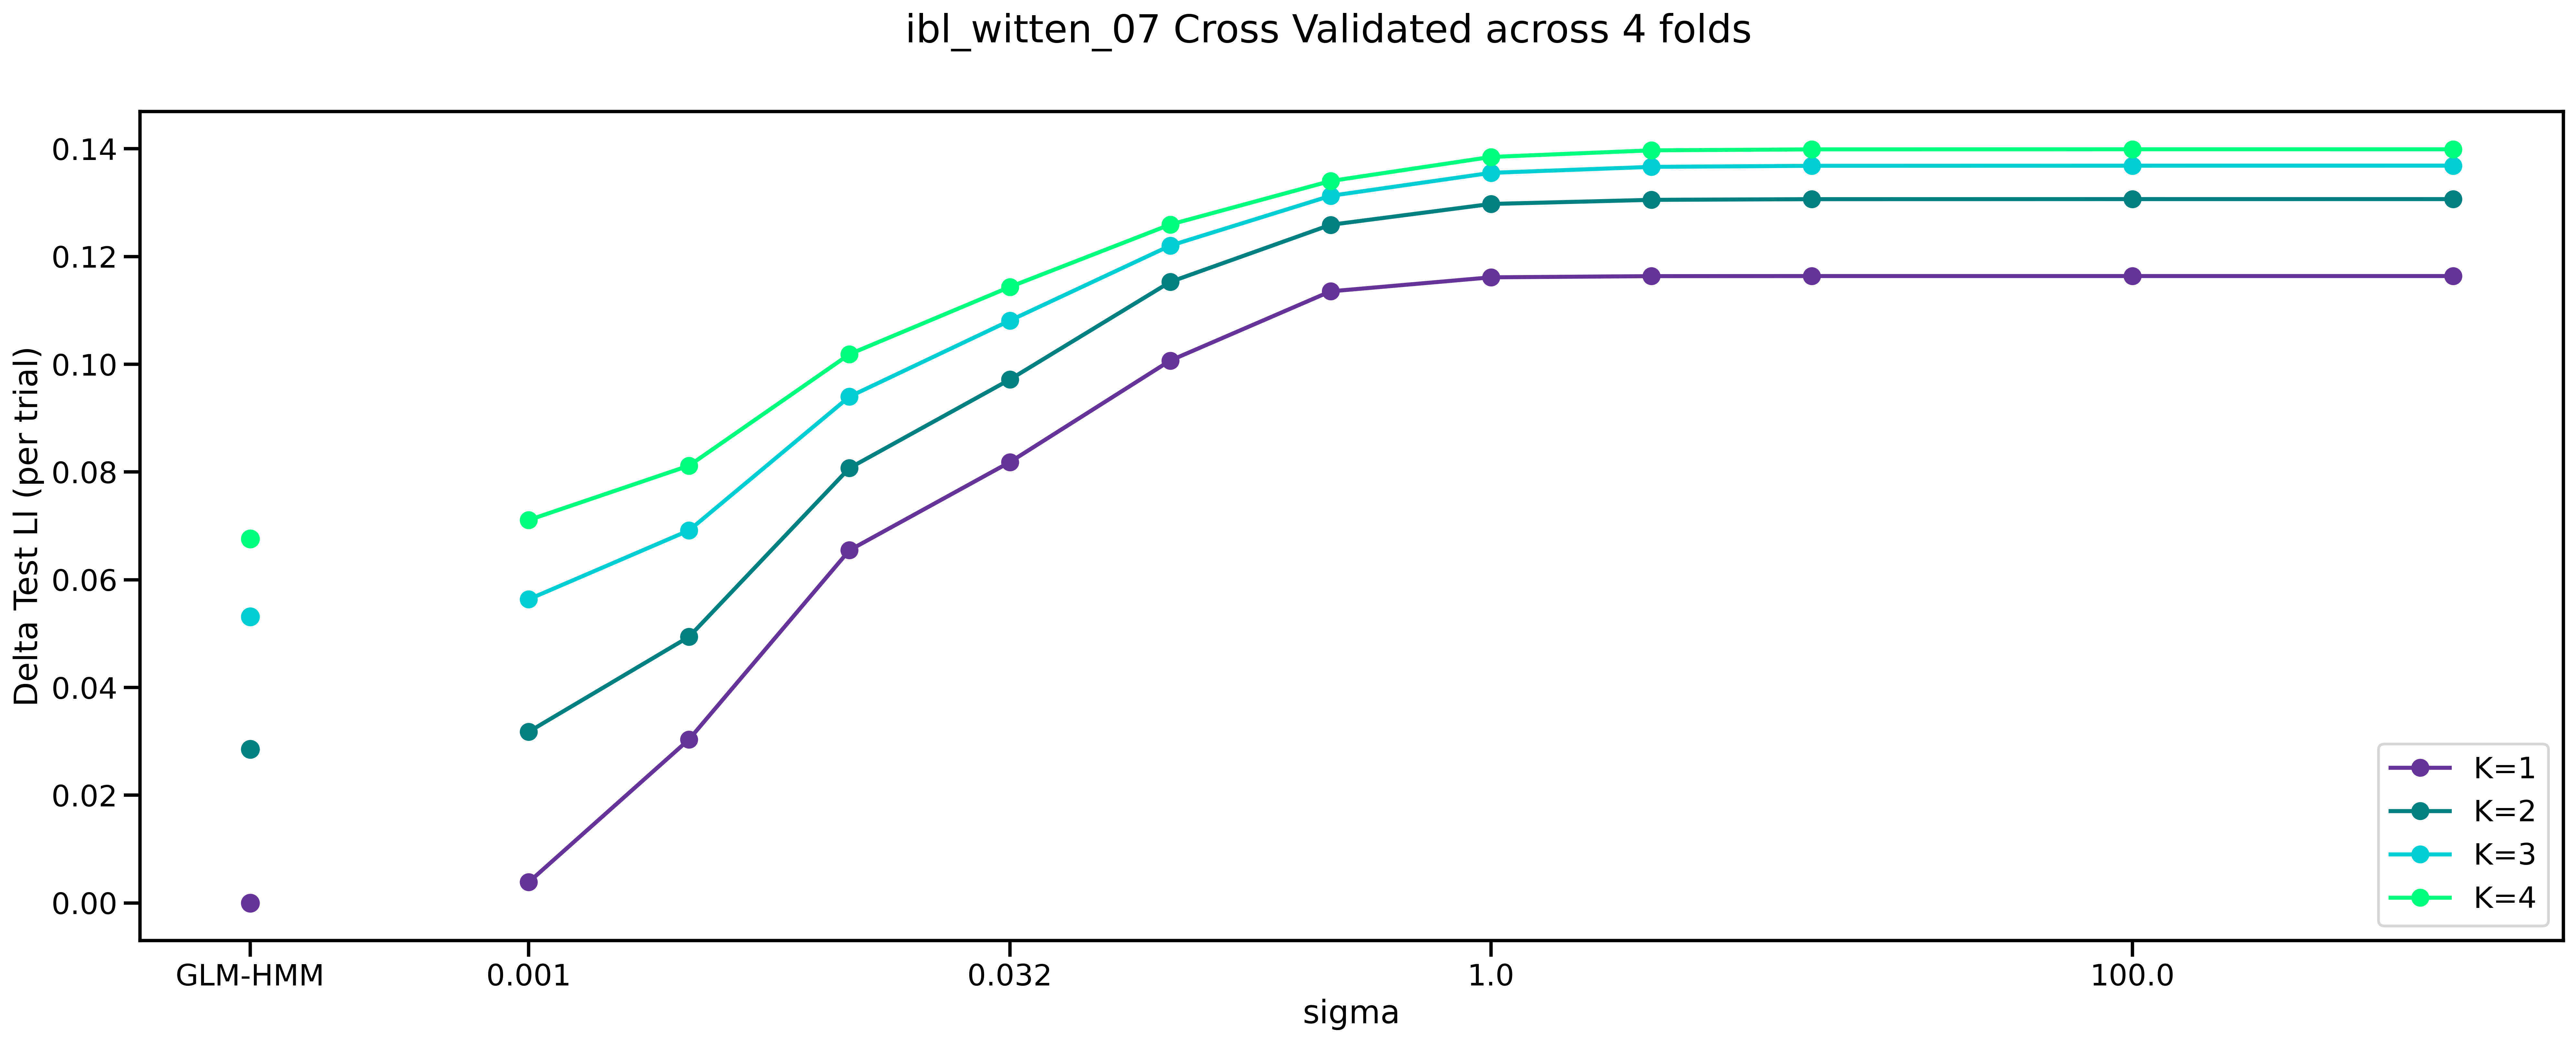

In [29]:
testLlAll = np.empty((4, len(sigmaList)))
bestTestLl = np.zeros((4,11))
bestTestAccuracy = np.zeros((4,11))

testLl = []
testAccuracy = []
avgTestLl = []
avgTestAccuracy = []
for K in [1,2,3,4]:
    for fold in range(0, splitFolds):
        testLl.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_testLl_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        testAccuracy.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_testAccuracy_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    avgTestLl.append(np.mean(testLl[:],axis=0))
    avgTestAccuracy.append(np.mean(testAccuracy[:],axis=0))
avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1
avgTestAccuracy = [x - avgTestAccuracy[0][0] for x in avgTestAccuracy]
    
for K in [1,2,3,4]:
    testLlAll[K-1] = avgTestLl[K-1]

bestSigmaInd = 7 # Choosing best sigma index across animals
for K in [1,2,3,4]:
    bestTestLl[K-1] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][bestSigmaInd] # delta
    bestTestAccuracy[K-1] = avgTestAccuracy[K-1][bestSigmaInd] - avgTestAccuracy[0][bestSigmaInd] # delta

# # Plotting each fold indiviudally for per-animal plots
# fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
# fig.suptitle(f'{subject}')
# for K in range(1,5):
#     for fold in range(0, splitFolds):
#         plot_testLl_CV_sigma(testLl[splitFolds*(K-1)+fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes)
    
# Plotting delta test ll averaged across folds for per-animal plots
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{exampleSubject} Cross Validated across 4 folds')
fig.tight_layout()
for K in range(1,5):
    plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
axes.set_ylabel("Delta Test Ll (per trial)")

Text(11.25, 0.5, '  test log-like (per trial)')

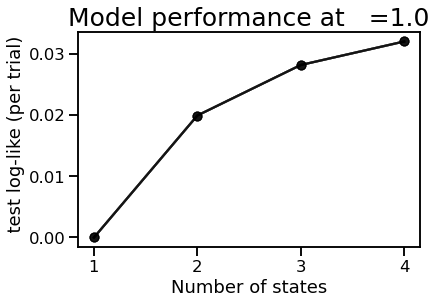

In [13]:
fig, axes = plt.subplots(1, figsize=(6,4))#, dpi=400)
fig.tight_layout()
axes.plot([1,2,3,4],bestTestLl[:],'-o', color='black',alpha=0.2)
axes.set_xticks([1,2,3,4])
axes.set_title(f'Model performance at   ={np.round(sigmaList[bestSigmaInd],2)}', fontsize=25)
axes.set_xlabel('Number of states')
axes.set_ylabel('  test log-like (per trial)')

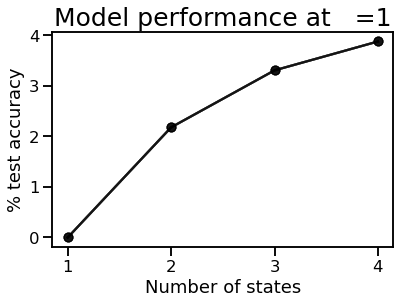

In [6]:
bestSigmaInd = 7 # Sigma to look at parameters for
fig, axes = plt.subplots(1,figsize=(6,4))#, dpi=400)
fig.tight_layout()
axes.set_title(f'Model performance at   =1', fontsize=25)
axes.set_xlabel('Number of states')
axes.set_ylabel('% test accuracy')
axes.plot([1,2,3,4],bestTestAccuracy[:],'-o', color='black',alpha=0.2)
axes.set_xticks([1,2,3,4])

Text(0.5, 1.05, 'Recovered weights for 3-state dGLM-HMM on example mouse')

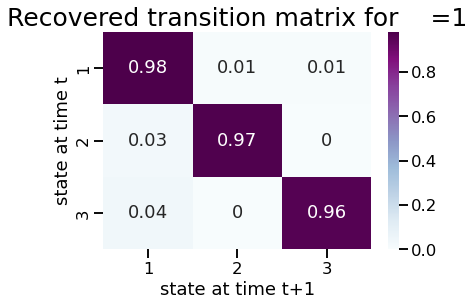

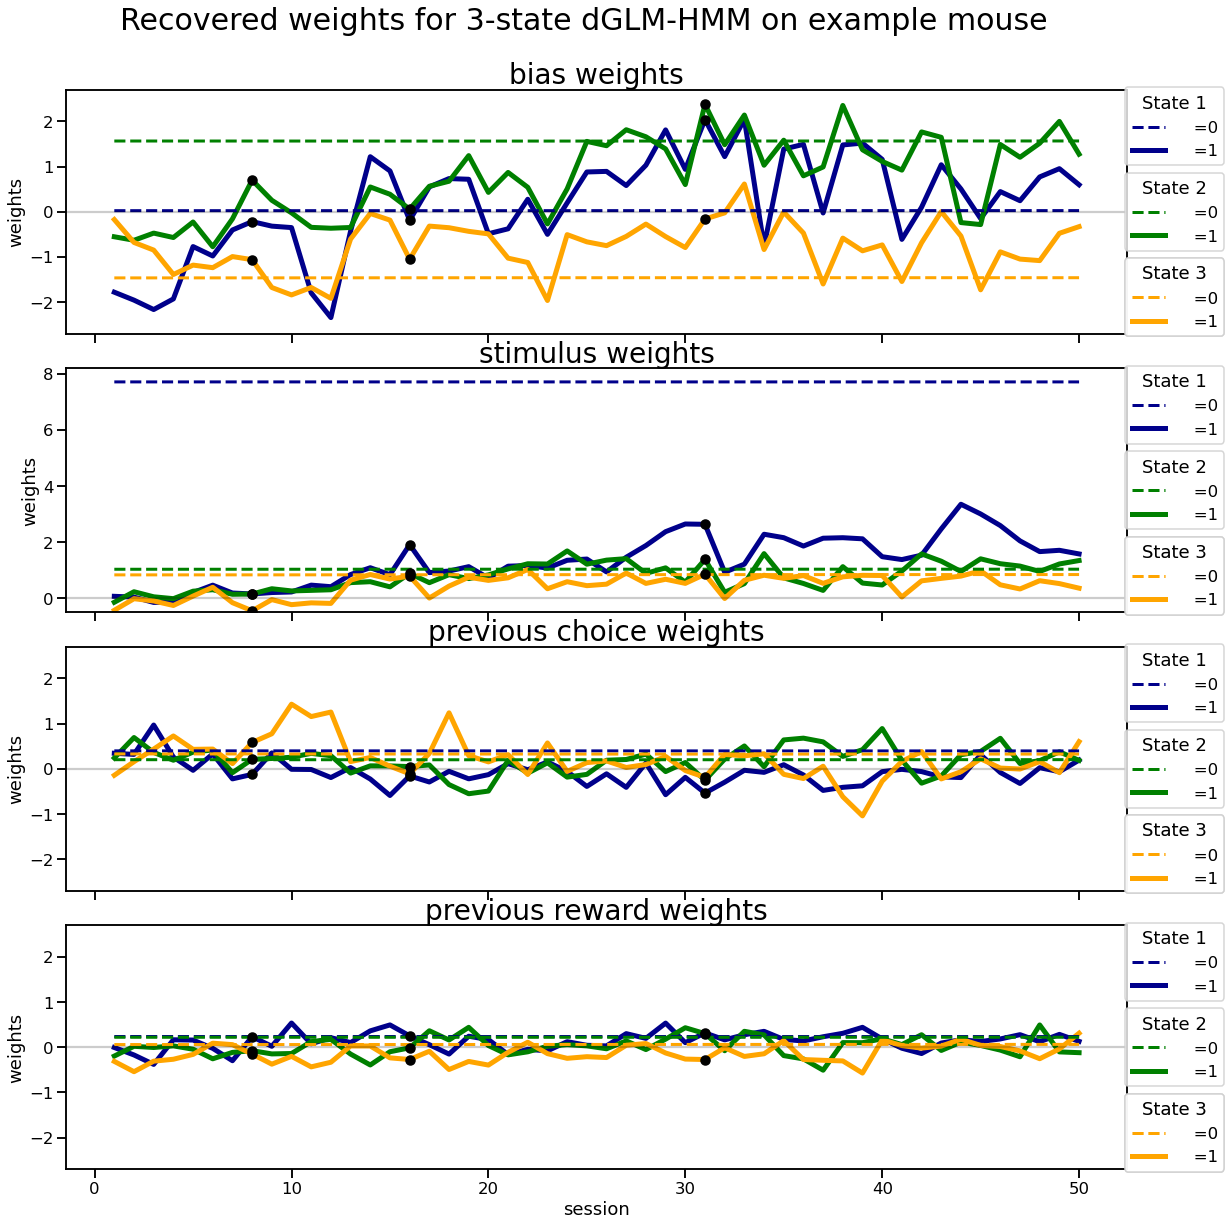

In [30]:
# Plotting Weights
K = 3
sessionsInterest = [7,15,30]
bestSigmaInd = 7

allP = []
allW = []
allW0 = []
sns.set_context("talk")

myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]

for fold in range(0, splitFolds):
    allP.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_P_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    allW.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_W_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    allW0.append(allW[fold][1]) # standard GLM-HMM is the same across folds

    # # plotting transition matrix individually 
    # fig, axes = plt.subplots()
    # plot_transition_matrix(allP[fold][bestSigmaInd], sortedStateInd=None) # not sorted

    # # plotting weights for each fold individually
    # fig, axes = plt.subplots(D, 1,figsize=(16,4*D+1), sharex=True)
    # fig.suptitle(f'{subject}: sigma = {np.round(sigmaList[bestSigmaInd],2)} fold {fold}')
    # fig.tight_layout()
    # plotting_weights_per_feature(allW[fold][bestSigmaInd], sessInd, axes, yLim=[[-2.5,2.5],[-6.2,6.2]], colors=colorsStates, labels=myFeatures[D%2], linewidth=5, linestyle='-', sortedStateInd=None)
        
avgP = np.mean(allP[:], axis=0)
avgW = np.mean(allW[:], axis=0)
avgW0 = np.mean(allW0[:], axis=0)

# computing gamma for bestSigmaInd
gamma = dGLM_HMM.get_posterior_latent(avgP[bestSigmaInd], truepi, avgW[bestSigmaInd], x, y, presentAll, sessInd, sortedStateInd=None)

# plotting transition matrix averaged across folds
fig, axes = plt.subplots()#dpi=400)
plot_transition_matrix(np.round(avgP[bestSigmaInd],2), title=f'Recovered    =1', sortedStateInd=None) # not sorted
axes.set_title('Recovered transition matrix for    =1', fontsize=25)
            
plotSess = min(len(sessInd)-1,50)
fig, axes = plt.subplots(D, 1,figsize=(16,16), sharex=True)#, dpi=400)
fig.tight_layout()
yLim=[[-2.7,2.7],[-0.5,8.2],[-2.7,2.7],[-2.7,2.7]]
for d in range(0, D):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-avgW0[sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=3, alpha=1, linestyle='--', label='   =0', zorder=1)
        axes[d].plot(range(1,plotSess+1),-avgW[bestSigmaInd][sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=5, alpha=1, linestyle='-', label='   =1', zorder=0)
        for s in sessionsInterest:
            axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
    lines = axes[d].get_lines()
    include = [1,2]
    legend1 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.85), title = "State 1")
    include = [3,4]
    legend2 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.5), title = "State 2")
    include = [5,6]
    legend3 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.15), title = "State 3")
    axes[d].add_artist(legend1)
    axes[d].add_artist(legend2)
    axes[d].add_artist(legend3)
    axes[d].set_ylim(yLim[d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights')
    axes[d].set_title(f'{myFeatures[D%2][d]} weights', fontsize=28)
axes[3].set_xlabel('session')
sns.set_context("talk")
fig.suptitle('Recovered weights for 3-state dGLM-HMM on example mouse', fontsize=30, y=1.05)

(45.0, 100.0)

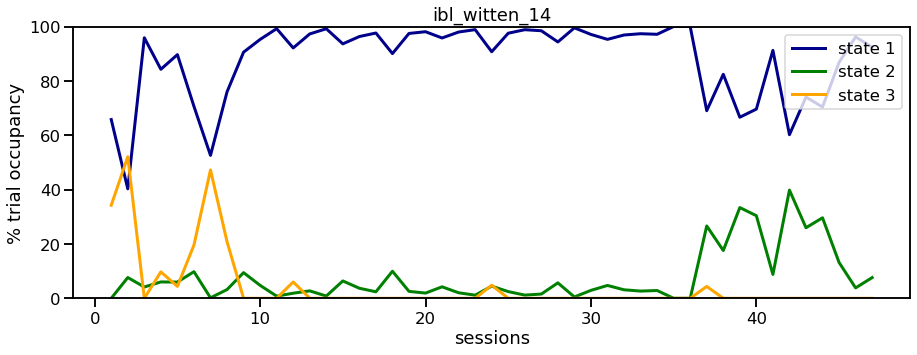

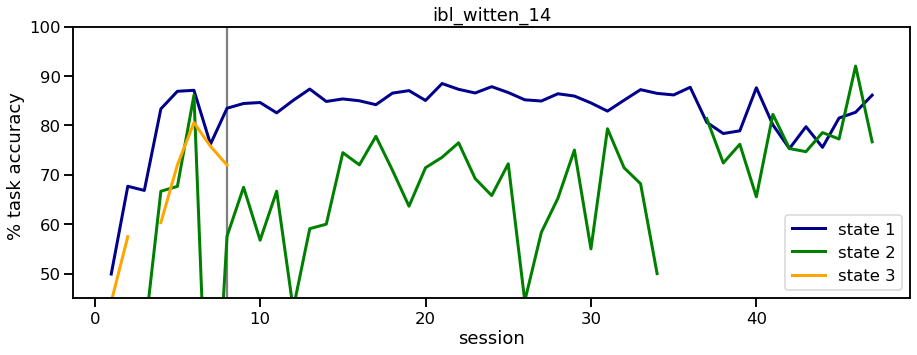

In [14]:
# Plotting task occupancy of each state across sessions
fig, axes = plt.subplots(1, figsize = (15,5))#, dpi=400)
axes.set_title(exampleSubject)
plot_state_occupancy_sessions(gamma, sessInd, axes, colors=colorsStates)

# plotting task accuracy in each state across sessions
fig, axes = plt.subplots(1, figsize = (15,5))#, dpi=400)
axes.set_title(exampleSubject)
plot_task_accuracy_states_sessions(gamma, y, correctSide, sessInd, axes, firstBlockSession=firstBlockSession, colors=colorsStates)
axes.set_ylim(45,100)

/Volumes/Lenca_SSD/github/Pillow_dGLM-HMM/code/plotting_utils.py:310: RuntimeWarning: invalid value encountered in double_scalars
  correct[sess, k] = correct[sess, k] / np.where(stateHard[sessInd[sess]:sessInd[sess+1]] == k)[0].shape[0] * 100


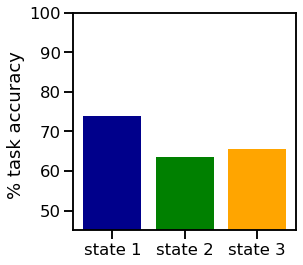

In [15]:
# Plotting animal's task accuracy in each state for specific sessions or averaged across sessions
fig, axes = plt.subplots(1, figsize = (4,4))#, dpi=400)
barplot_task_accuracy(gamma, y, correctSide, sessInd, axes, session='all', colors=colorsStates)

# # for sessions of Interest
# for sess in sessionsInterest:
#     fig, axes = plt.subplots(1, figsize = (4,4))#, dpi=400)
#     barplot_task_accuracy(gamma, y, correctSide, sessInd, axes, session=sess, colors=colorsStates) 

In [ ]:
# TRY CORRELATE ALIGNMENT OF BIAS WITH TASK PERFORMANCE OF ANIMAL!!!

# Look at model's performance if stimulus weights are ???

In [30]:
# Average latents across right blocks aligned?

/Volumes/Lenca_SSD/github/Pillow_dGLM-HMM/code/plotting_utils.py:348: RuntimeWarning: Mean of empty slice
  axes.plot(range(1,len(sessInd)), np.nanmean(np.array([blocksStateRight,blocksStateLeft]),axis=0), color='black',label='mean')


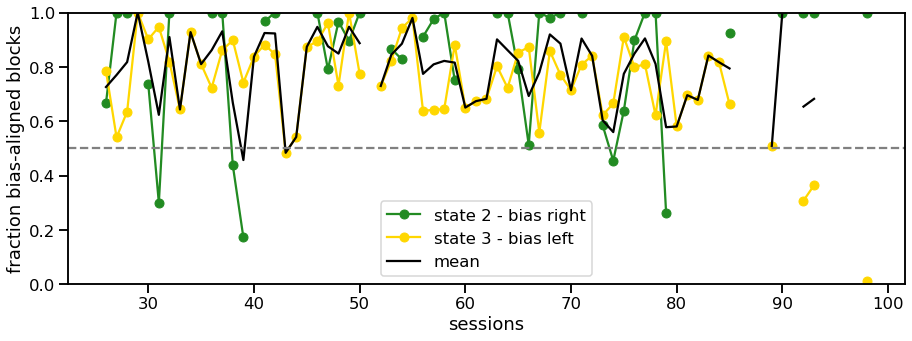

In [16]:
# Plotting alignment of biased states with biased blocks
fig, axes = plt.subplots(1, figsize=(15,5))
plot_aligned_fraction_blocks_state(gamma, sessInd, biasedBlockTrials, biasedBlockSession, axes)

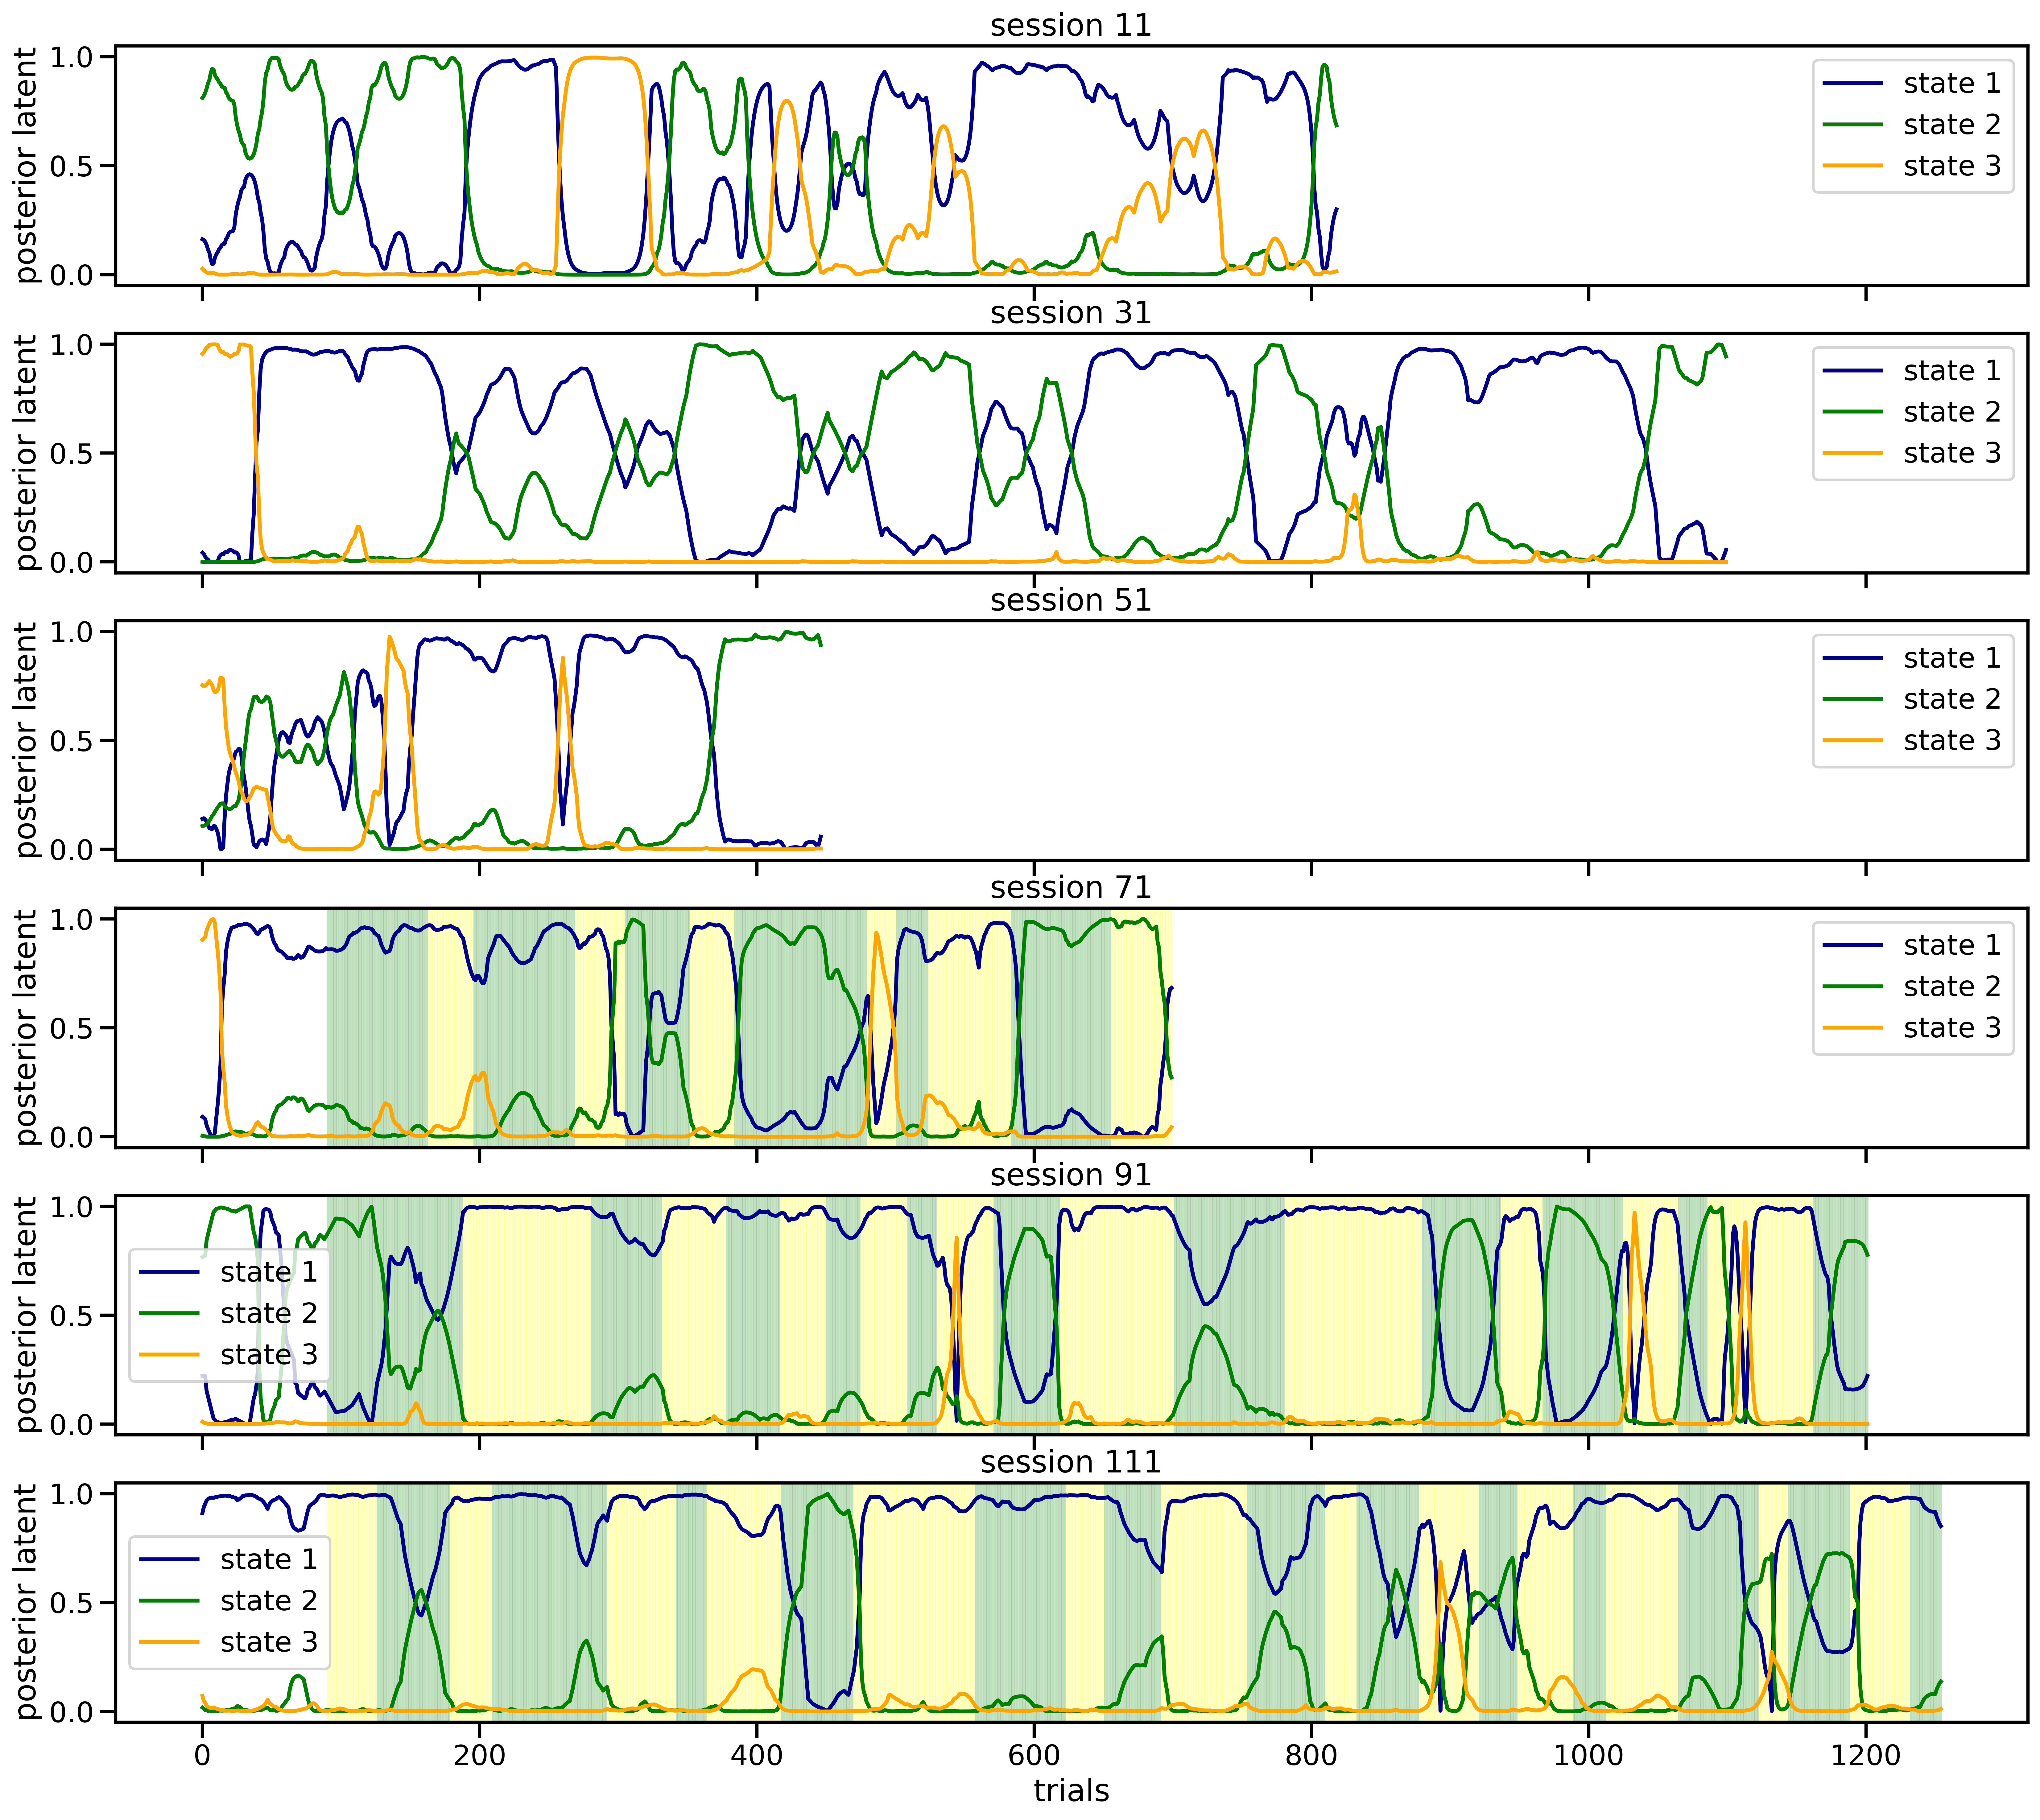

In [32]:
sessionsInterest = [10, 30, 50, 70, 90, 110]
bestSigmaInd = 7

fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(20,3*len(sessionsInterest)), dpi=400, sharex=True)
plot_posteior_latent(gamma, sessInd, axes, sessions = sessionsInterest)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    for t in range(sessInd[sess],sessInd[sess+1]):
        if (biasedBlockTrials[t] == 1):
            axes[s].axvline(t-sessInd[sess], color='green', label='right block', zorder=0, alpha=0.25, linewidth=0.85)
        elif (biasedBlockTrials[t] == -1):
            axes[s].axvline(t-sessInd[sess], color='yellow', label='left block', zorder=0, alpha=0.25, linewidth=0.85)
# fig.savefig('../figures/Latent_Example_10sessions_mouse_ibl_witten_15.png')



### Varying transition matrix P

In [20]:
exampleSubject = 'ibl_witten_15'
alphaList = [2*(10**x) for x in list(np.arange(-1,6,0.5,dtype=float))]

testLl = []
testAccuracy = []
avgTestLl = []
avgTestAccuracy = []
for K in [3]: # 4
    allP = []
    allW = []
    for fold in range(0, splitFolds):
        allP.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_P_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))
        allW.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_W_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))
        testLl.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_testLl_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))
        testAccuracy.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_testAccuracy_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))
    avgTestLl.append(np.mean(testLl[:],axis=0))
    avgTestAccuracy.append(np.mean(testAccuracy[:],axis=0))
    avgP = np.mean(allP[:], axis=0)
    avgW = np.mean(allW[:], axis=0)
avgTestLl = [x - avgTestLl[-1][0] for x in avgTestLl] # normalizing to dGLM-HMM1 K=1
avgTestAccuracy = [x - avgTestAccuracy[0][0] for x in avgTestAccuracy]
        

(0.91, 0.98)

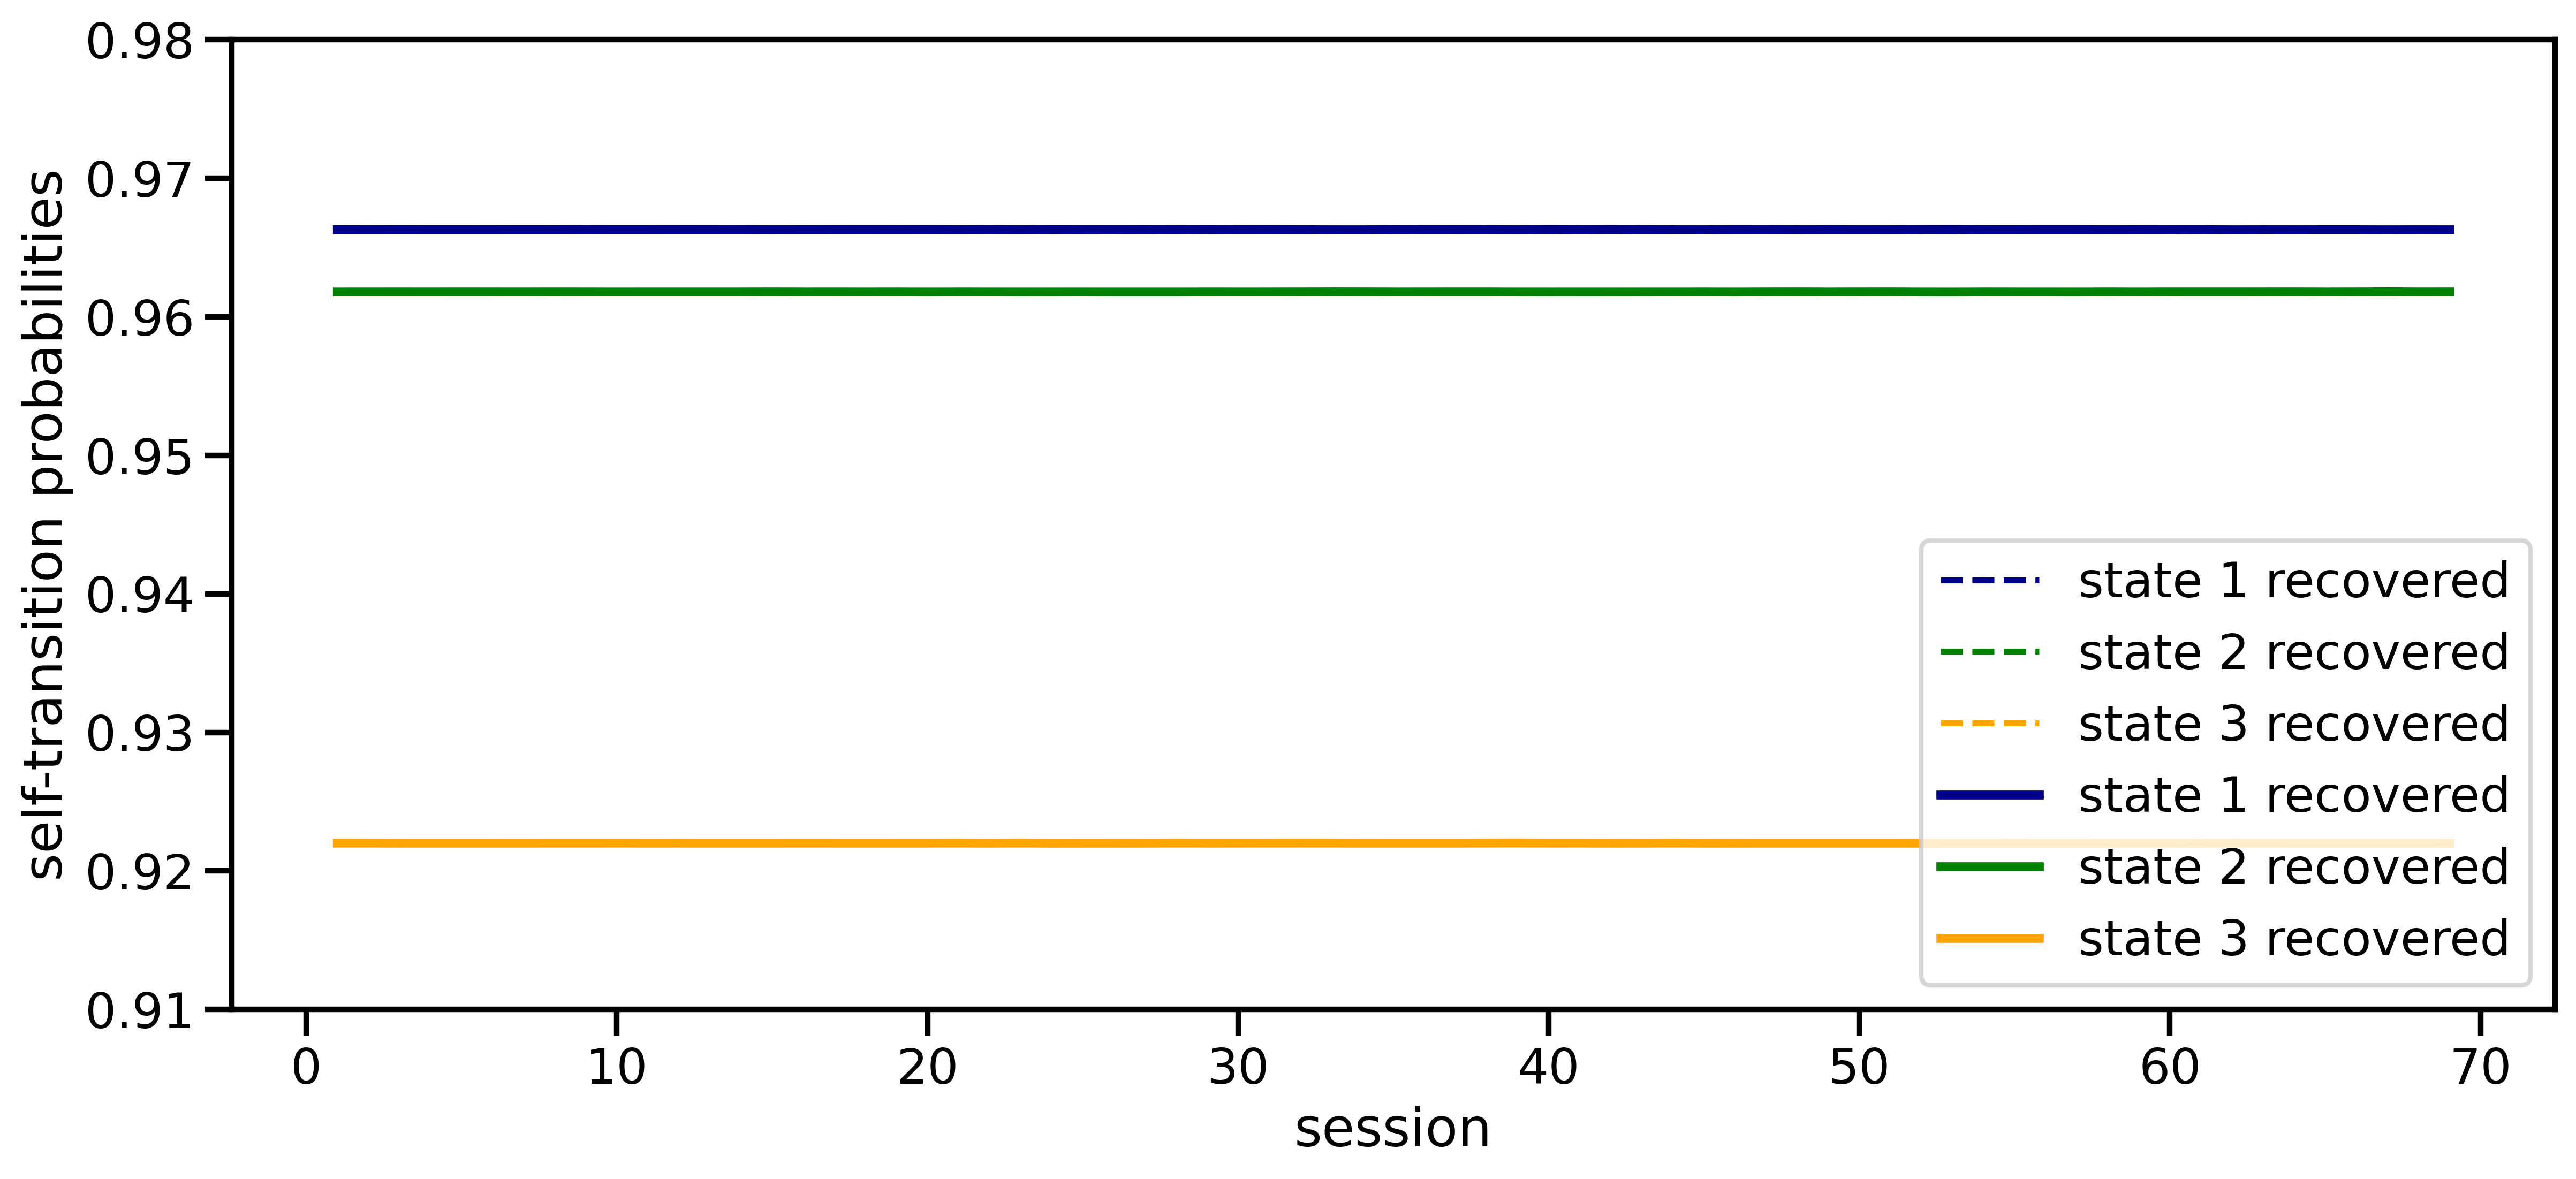

In [35]:
fig, axes = plt.subplots(1, figsize = (14,6), dpi=400)
plotting_self_transition_probabilities(avgP[-1], sessInd, axes, trueP=None, linestyle='--', linewidth=2, title='', save_fig=False, colorsStates=colorsStates, sortedStateInd=None)
plotting_self_transition_probabilities(avgP[-2], sessInd, axes, trueP=None, linestyle='-', linewidth=3, title=f'', save_fig=False, colorsStates=colorsStates, sortedStateInd=None)
axes.set_ylim(0.91,0.98)

In [26]:
print(avgP[-1][0])

[[9.66289400e-01 1.74646923e-02 1.62459074e-02]
 [3.82067759e-02 9.61793213e-01 1.08819201e-08]
 [7.79690391e-02 1.60078646e-05 9.22014953e-01]]


In [31]:
print(np.mean(avgP[-1] - avgP[-2]))
print(np.mean(avgW[-1] - avgW[-2]))

1.8463056865419016e-18
-0.0007901023814935223


In [30]:
print(avgW.shape)

(15, 68237, 3, 4, 2)


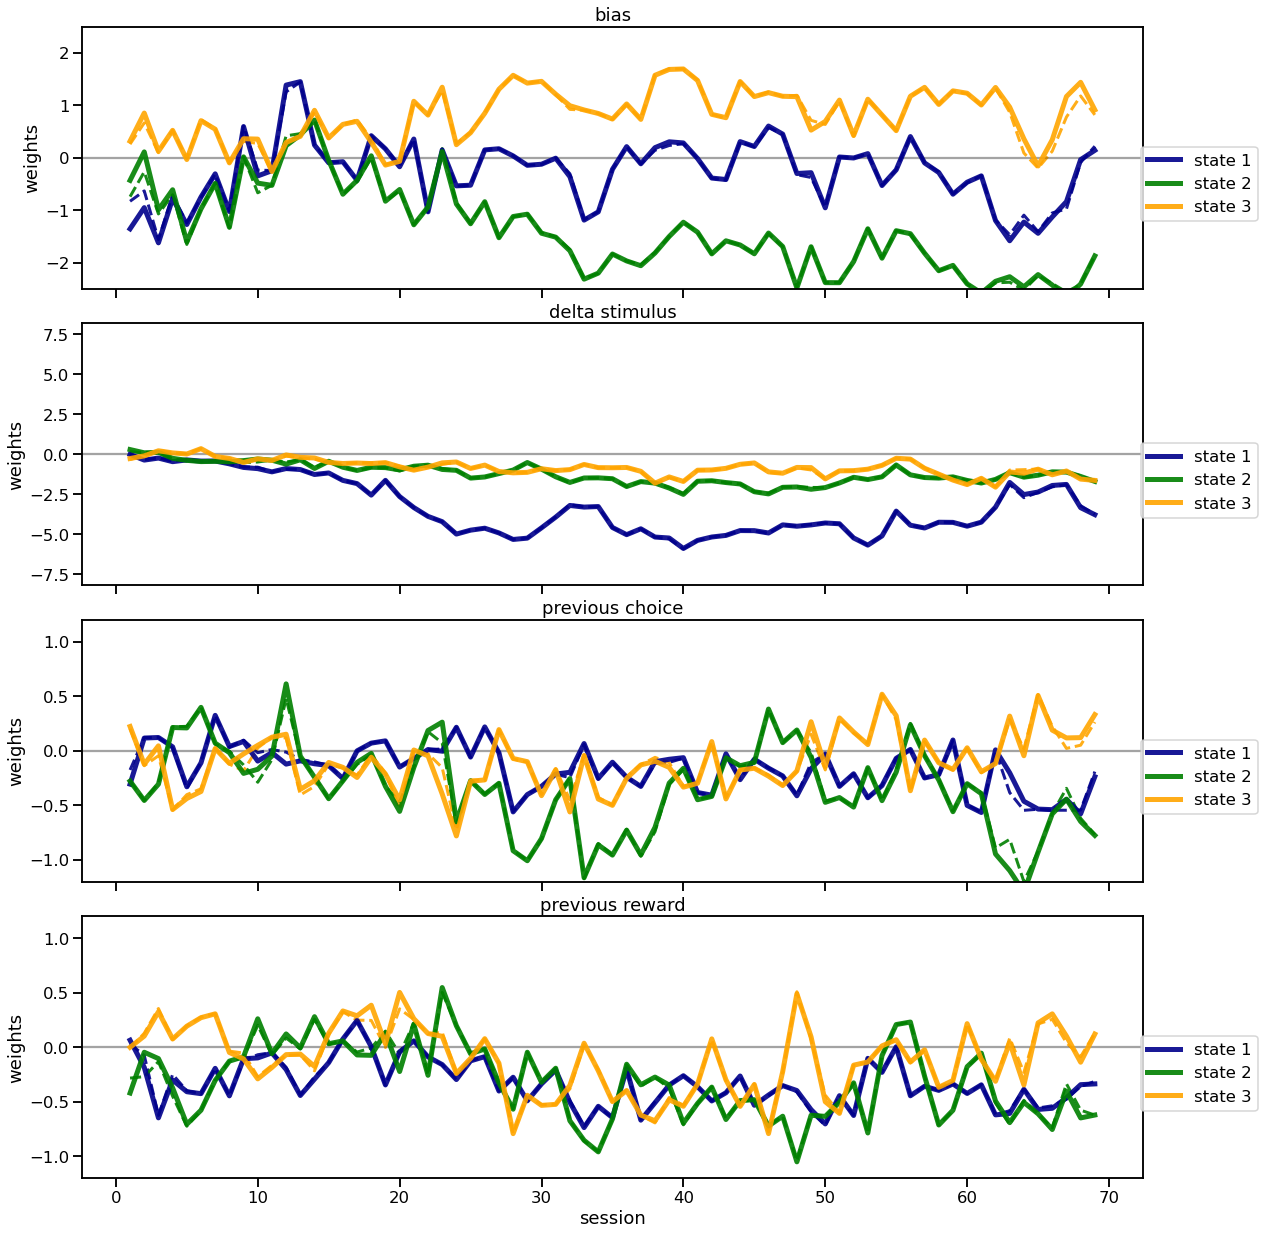

In [29]:
fig, axes = plt.subplots(D, 1,figsize=(16,4*D+1), sharex=True)
fig.tight_layout()
plotting_weights_per_feature(avgW[-1], sessInd, axes, yLim=[[-2.5,2.5],[-8.2,8.2], [-1.2,1.2],[-1.2,1.2]], colors=colorsStates, labels=myFeatures[D%2], linewidth=3, linestyle='--', sortedStateInd=None, legend=False)
plotting_weights_per_feature(avgW[-2], sessInd, axes, yLim=[[-2.5,2.5],[-8.2,8.2], [-1.2,1.2],[-1.2,1.2]], colors=colorsStates, labels=myFeatures[D%2], linewidth=5, linestyle='-', sortedStateInd=None)
        